In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import random_split

In [4]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [5]:
dataset = ImageFolder("leapGestRecog",transform=transforms.ToTensor())
train_size = int(0.75 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset,[train_size, val_size, test_size])

In [6]:
train_loader=torch.utils.data.DataLoader(train_set,batch_size=128)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=128)
val_loader=torch.utils.data.DataLoader(val_set,batch_size=128)

In [7]:
#function to calculate the accuracy of the model
from sklearn.metrics import precision_recall_fscore_support
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
def accuracy(test_loader, model):
    test_correct_predicted=0
    test_predicted_labels=[]
    test_true_labels=[]
    model.eval()
    with torch.no_grad():
        for image,label in test_loader:
            output=model(image)
            _,predicted=torch.max(output.data,1)
            test_correct_predicted+=(predicted==label).sum().item()
            test_predicted_labels.extend(predicted.tolist())
            test_true_labels.extend(label.tolist())
    testing_accu=test_correct_predicted/len(test_loader.dataset)
    testing_precision, testing_recall, testing_f1_score, _ = precision_recall_fscore_support(test_true_labels, test_predicted_labels, average='macro')
    return testing_accu, testing_precision, testing_recall, testing_f1_score



In [8]:
model = AlexNet(10)
checkpoint = torch.load('model.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
accuracy(test_loader,model)

(0.999, 0.99902150615571, 0.9990192682398789, 0.9990176989481514)

#### Displaying random images to check the predicted labels

In [12]:
import random
import matplotlib.pyplot as plt
import numpy as np

def display_sample(sample_image, sample_label, sample_predicted_label):
    # Display the image and predicted label
    plt.imshow(np.transpose(sample_image.numpy(), (1, 2, 0)))
    plt.title('True Label: {}\nPredicted Label: {}'.format(sample_label, sample_predicted_label))
    plt.show()

def display_samples(test_loader, model):
    model.eval()
    # Geting labels in the test dataset
    if isinstance(test_loader.dataset, torch.utils.data.Subset):
        dataset = test_loader.dataset.dataset
    else:
        dataset = test_loader.dataset
    class_labels = dataset.classes
    # Displaying sample images and predicted labels
    samples = min(len(test_loader.dataset), 25)
    random_indices = random.sample(range(len(test_loader.dataset)), samples)
    for i in random_indices:
        image, label = test_loader.dataset[i]
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_label = class_labels[predicted.item()]
        display_sample(image, class_labels[label], predicted_label)



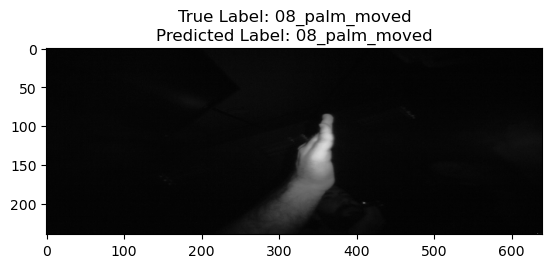

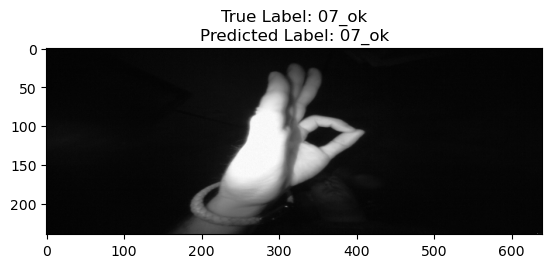

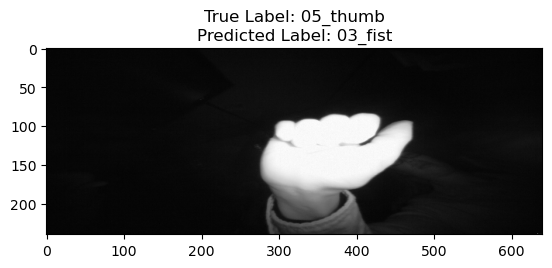

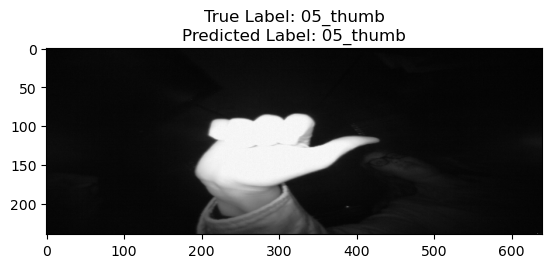

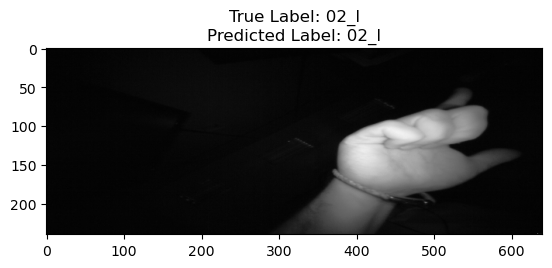

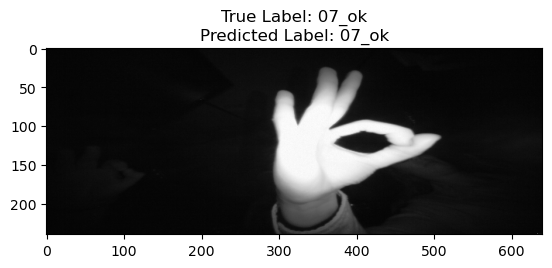

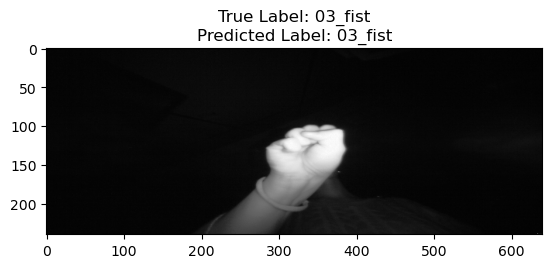

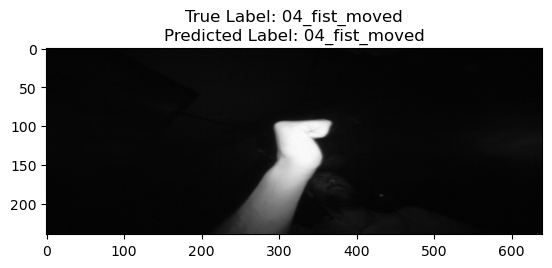

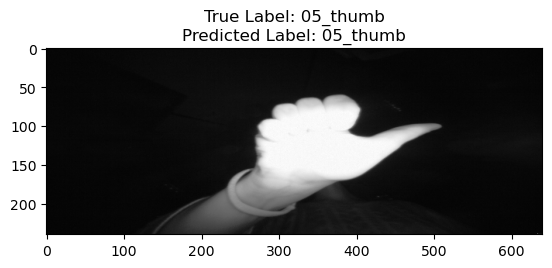

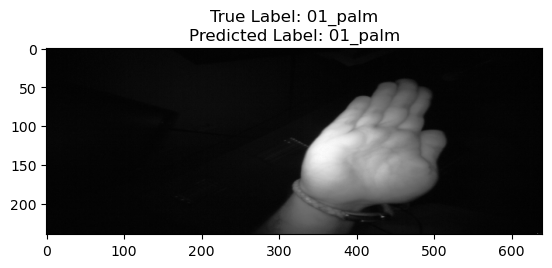

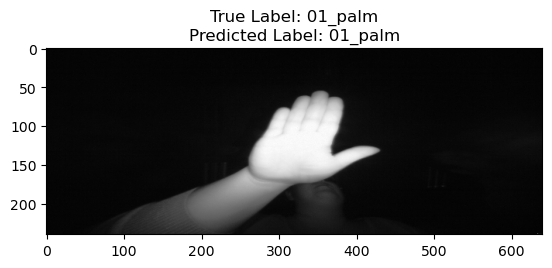

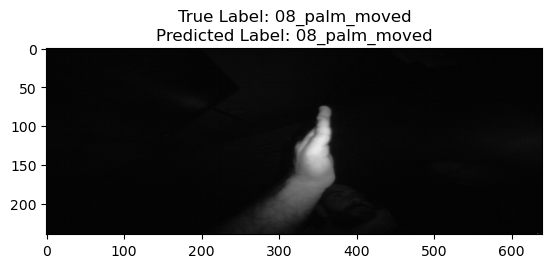

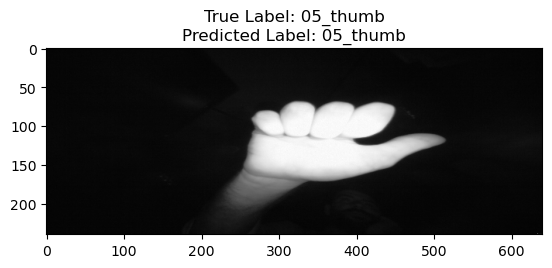

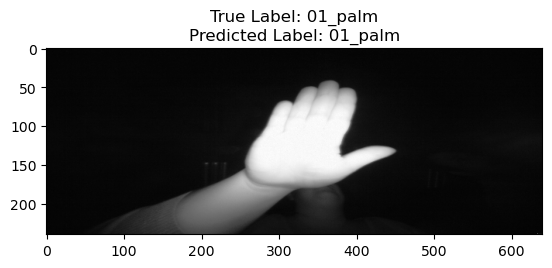

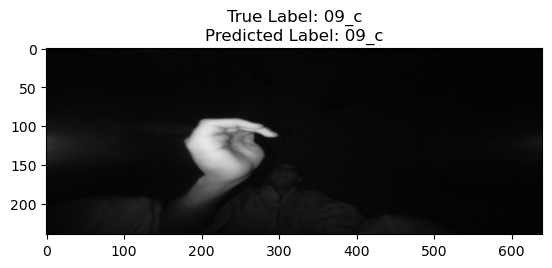

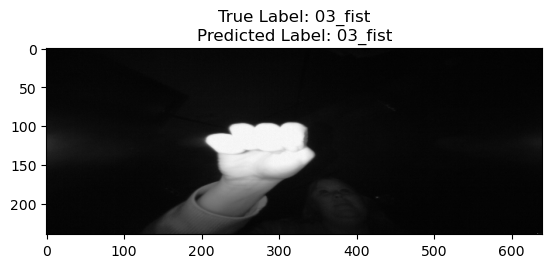

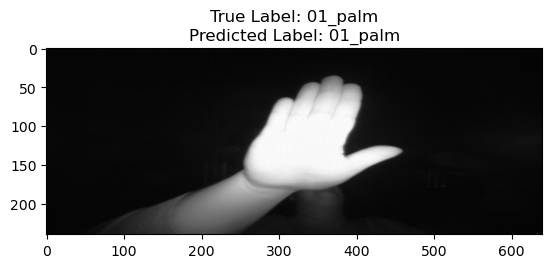

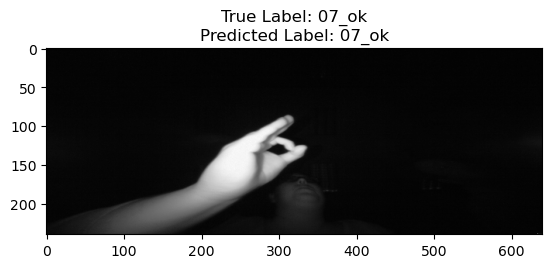

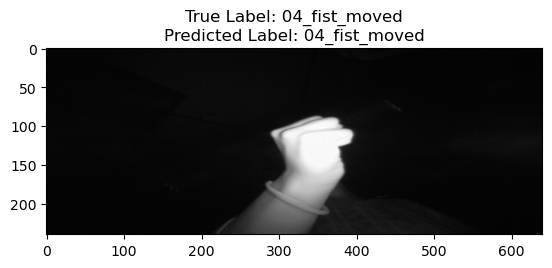

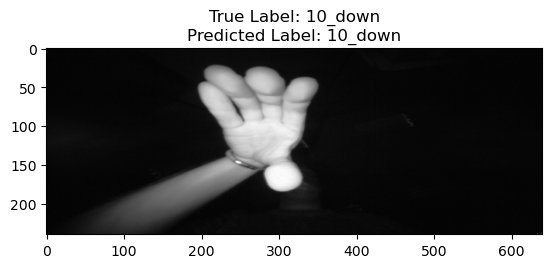

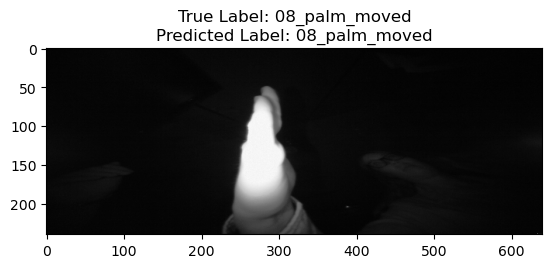

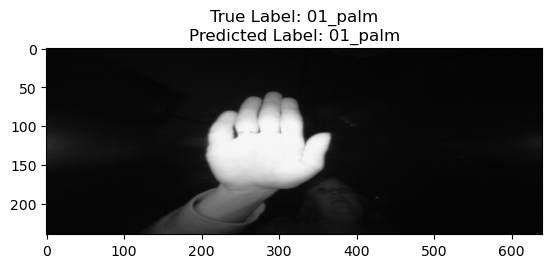

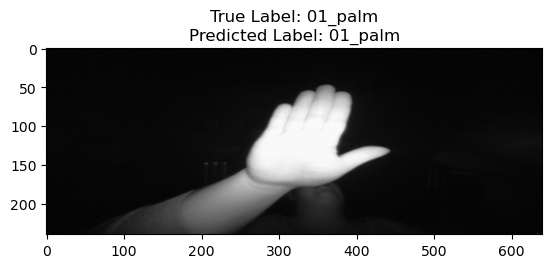

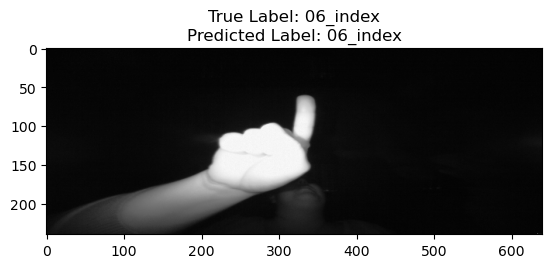

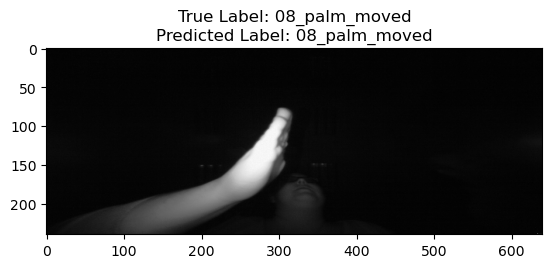

In [13]:
model = AlexNet(10)
checkpoint = torch.load('model.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
display_samples(test_loader,model)

##### we tried to integrate our model with camera but it doesnt performed well but we are keeping it here just to showcase our work


In [4]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from torchvision.models import alexnet

# Load the pre-trained AlexNet model
model = AlexNet(10)
checkpoint = torch.load('model.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model.eval()
camera = cv2.VideoCapture(1)
# Define the transformations to be applied to the input image
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the class labels for hand gestures
labels = ["palm","l","fist","fist_moved","thumb","index","ok","palm_moved","c","down"]

# Process the webcam feed
while True:
    # Read a frame from the webcam
    _, frame = camera.read()
    # Flip the frame horizontally for a mirror effect
    frame = cv2.flip(frame, 1)
    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # Threshold the image to get binary segmentation
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # Find contours in the thresholded image
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        # Find the contour with the maximum area
        max_contour = max(contours, key=cv2.contourArea)
        # Create a bounding rectangle around the contour
        x, y, w, h = cv2.boundingRect(max_contour)
        # Extract the hand segment from the frame
        hand_segment = gray[y:y+h, x:x+w]
        # Preprocess the hand segment
        hand_segment = cv2.resize(hand_segment, (224, 224))
        hand_segment = cv2.cvtColor(hand_segment, cv2.COLOR_GRAY2RGB)
        input_tensor = transform(hand_segment).unsqueeze(0)
        # Forward pass through the model
        with torch.no_grad():
            output = model(input_tensor)
        # Get the predicted class label
        _, predicted_idx = torch.max(output, 1)
        predicted_label = labels[predicted_idx.item()]
        # Display the predicted label on the frame
        cv2.putText(frame, predicted_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        # Draw the bounding rectangle around the hand segment
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    # Display the frame
    cv2.imshow('Hand Gesture Recognition', frame)
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# Release the webcam and close the window
camera.release()
cv2.destroyAllWindows()

1   HIToolbox                           0x00007ff825692726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff8256922b8 _ZN15MenuBarInstance14EnableAutoShowEv + 52
3   HIToolbox                           0x00007ff825601cd7 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1113
4   HIToolbox                           0x00007ff825692173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
5   AppKit                              0x00007ff81eb594b7 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
6   AppKit                              0x00007ff81e9ae165 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
7   CoreFoundation                      0x00007ff81b78d6d6 __CFNOTIFICATIONCENTER_IS_CALLING_OUT_TO_AN_OBSERVER__ + 137
8   CoreFoundation                      0x00007ff81b826cbc ___CFXRegistrationPost_block_invoke + 86
9   CoreFoundation                      0x00007ff81b826c13 _CFXR